# goes-orthorectify

Orthorectify and clip a GOES ABI image using the mapping created by goes-make-orth-map

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os

#import warnings
#warnings.filterwarnings('ignore')

In [12]:
def LonLat2ABIangle(lon_deg, lat_deg, z, H, req, rpol, e, lon_0_deg):
    '''This function finds the ABI elevation (y) and scanning (x) angles (radians) of point P, 
    given a latitude and longitude (degrees)'''
    
    # convert lat and lon from degrees to radians
    lon = np.radians(lon_deg)
    lat = np.radians(lat_deg)
    lon_0 = np.radians(lon_0_deg)
      
    # geocentric latitude
    lat_geo = np.arctan( (rpol**2 / req**2) * np.tan(lat) )

    # geocentric distance to point on the ellipsoid
    _rc = rpol / np.sqrt(1 - (e**2)*(np.cos(lat_geo)**2)) # this is rc if point is on the ellipsoid
    rc = _rc + z # this is rc if the point is offset from the ellipsoid by z (meters)

    # intermediate calculations
    Sx = H - rc * np.cos(lat_geo) * np.cos(lon - lon_0)
    Sy = -rc * np.cos(lat_geo) * np.sin(lon - lon_0)
    Sz = rc * np.sin(lat_geo)
    
    # calculate x and y scan angles
    y = np.arctan( Sz / Sx )
    x = np.arcsin( -Sy / np.sqrt( Sx**2 + Sy**2 + Sz**2 ) )
    
    ## determine if this point is visible to the satellite
    #condition = ( H * (H-Sx) ) < ( Sy**2 + (req**2 / rpol**2)*Sz**2 )
    #if condition == True:
    #    print('Point at {},{} not visible to satellite.'.format(lon_deg,lat_deg))
    #    return (np.nan, np.nan)
    #else:
    #    return (x,y)
    return (x,y)


def make_ortho_map(abi_image, dem):
    '''For the entire DEM, determine the ABI scan angle coordinates for every DEM grid cell, 
    taking into account the underlying terrain and satellite's viewing geometry'''
    print('\nRUNNING: make_ortho_map()')
    
    
    # Get inputs: projection information from the ABI radiance product (values needed for geometry calculations)
    print('\nGet inputs: projection information from the ABI radiance product')
    req = abi_image.goes_imager_projection.semi_major_axis
    rpol = abi_image.goes_imager_projection.semi_minor_axis
    H = abi_image.goes_imager_projection.perspective_point_height + abi_image.goes_imager_projection.semi_major_axis
    lon_0 = abi_image.goes_imager_projection.longitude_of_projection_origin
    e = 0.0818191910435 # GRS-80 eccentricity
    print('...done')
    
    # Create 2D arrays of longitude and latitude from the DEM
    print('\nCreate 2D arrays of longitude and latitude from the DEM')
    X, Y = np.meshgrid(dem.x,dem.y) # Lon and Lat of each DEM grid cell
    Z = dem.values # elevation of each DEM grid cell
    print('...done')
    
    # For each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)
    print('\nFor each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)')
    abi_grid_x, abi_grid_y = LonLat2ABIangle(X,Y,Z,H,req,rpol,e,lon_0)
    print('...done')
    
    # Create metadata dictionary about this map (should probably clean up metadata, adhere to some set of standards)
    print('\nCreate metadata dictionary about this map')
    metadata = {
                # Information about the projection geometry:
                'longitude_of_projection_origin': lon_0,
                'semi_major_axis': req,
                'semi_minor_axis': rpol,
                'satellite_height': H,
                'grs80_eccentricity': e,
        
                'longitude_of_projection_origin_info': 'longitude of geostationary satellite orbit',
                'semi_major_axis_info': 'semi-major axis of GRS 80 reference ellipsoid',
                'semi_minor_axis_info': 'semi-minor axis of GRS 80 reference ellipsoid',
                'satellite_height_info': 'distance from center of ellipsoid to satellite (perspective_point_height + semi_major_axis_info)',
                'grs80_eccentricity_info': 'eccentricity of GRS 80 reference ellipsoid',
    
                # Information about the DEM source file
                'dem_file': dem_filename,
                'dem_crs' : dem.crs,
                'dem_transform' : dem.transform,
                'dem_res' : dem.res,
                'dem_ifov': -9999, # TO DO
        
                'dem_file_info': 'filename of dem file used to create this mapping',
                'dem_crs_info' : 'coordinate reference system from DEM geotiff',
                'dem_transform_info' : 'transform matrix from DEM geotiff', 
                'dem_res_info' : 'resolution of DEM geotiff',
                'dem_ifov_info': 'instantaneous field of view (angular size of DEM grid cell)',
        
                # For each DEM grid cell, we have...
                'dem_px_angle_x_info': 'DEM grid cell X coordinate (east/west) scan angle in the ABI Fixed Grid',
                'dem_px_angle_y_info': 'DEM grid cell Y coordinate (north/south) scan angle in the ABI Fixed Grid',
                'longitude_info': 'longitude from DEM file',
                'latitude_info': 'latitude from DEM file',
                'elevation_info': 'elevation from DEM file'
    }
    print('...done')
    
    print('\nExport this pixel map along with the metadata (NetCDF with xarray)')
    # Export this pixel map along with the metadata (NetCDF with xarray)
    ds = xr.Dataset({    
                'elevation':          (['y', 'x'], dem.values)
                },
    
                coords={'longitude':  (['x'], dem.x),
                        'latitude':   (['y'], dem.y),
                        'dem_px_angle_x':     (['y', 'x'],  abi_grid_x),
                        'dem_px_angle_y':     (['y', 'x'],  abi_grid_y)},
                
                attrs=metadata)
                 
    ds.to_netcdf('test_map_tuol_2017.nc',mode='w')
    print('...done')
    
    # Return the pixel map dataset
    print('\nReturn the pixel map dataset.')
    
    return ds

def orthorectify_abi_rad(abi_image, pixel_map, filename=None):
    '''Using the pixel mapping for a specific ABI viewing geometry over a particular location,
    orthorectify the ABI radiance values and return an xarray dataarray with those values.'''
    print('\nRUNNING: orthorectify_abi_rad()')
    
    # First check, Does the projection info in the image match our mapping?
    print('\nDoes the projection info in the image match our mapping?')
    print('perspective_point_height + semi_major_axis:\t{}\t{}'.format(abi_image.goes_imager_projection.perspective_point_height 
                                                                       + abi_image.goes_imager_projection.semi_major_axis,
                                                          pixel_map.satellite_height))
    print('semi_major_axis:\t\t\t\t{}\t{}'.format(abi_image.goes_imager_projection.semi_major_axis,
                                                          pixel_map.semi_major_axis))
    print('semi_minor_axis:\t\t\t\t{}\t{}'.format(abi_image.goes_imager_projection.semi_minor_axis,
                                                          pixel_map.semi_minor_axis))
    print('longitude_of_projection_origin:\t\t\t{}\t\t{}'.format(abi_image.goes_imager_projection.longitude_of_projection_origin,
                                                          pixel_map.longitude_of_projection_origin))
    print('...done')
    
    # Map (orthorectify) and clip the image to the pixel map
    print('\nMap (orthorectify) and clip the image to the pixel map')
    abi_rad_values = abi_image.sel(x=pixel_map.dem_px_angle_x, y=pixel_map.dem_px_angle_y, method='nearest').Rad.values
    print('...done')
    # Output this result to a new NetCDF file
    print('\nOutput this result to a new NetCDF file')
    if filename == None:
        filename=abi_image.dataset_name+'_ortho.nc'
    print('Saving file as: {}'.format(filename))
    output_ortho_netcdf(abi_rad_values, pixel_map, filename)
    print('...done')
    
    return None



def output_ortho_netcdf(abi_rad_values, pixel_map, filename):
    '''Create a new xarray dataset with the orthorectified ABI radiance values, 
    Lat, Lon, Elevation, and metadata from the pixel map. 
    Then export this as a new NetCDF file.'''
    print('\nRUNNING: output_ortho_netcdf()')
    
    # some metadata for this
    metadata = {'rad' : 'units'}
    
    # make the data array
    rad_da = xr.DataArray(abi_rad_values, 
                          dims=('y','x'),
                          coords={'longitude': (['x'], pixel_map.longitude),
                                  'latitude': (['y'], pixel_map.latitude)},
                         attrs=metadata)
    pixel_map['rad'] = rad_da
    pixel_map.to_netcdf(filename)
    
    return None

#### Open a GOES ABI image:

In [13]:
#image_path = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\21\ABI-L1b-RadC\15\C02\OR_ABI-L1b-RadC-M4C02_G16_s20171111520224_e20171111525027_c20171111525034.nc'
image_path =  r'\\j-lundquist-3.ce.washington.edu\storage\GOES\goes16\2017\04\21\ABI-L1b-RadC\17\C14\OR_ABI-L1b-RadC-M4C14_G16_s20171111750224_e20171111755027_c20171111755074.nc'
#image_path = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\goes16\2019\04\16\ABI-L1b-RadC\18\C02\OR_ABI-L1b-RadC-M6C02_G16_s20191061801182_e20191061803555_c20191061803598.nc'

abi_image = xr.open_dataset(image_path)
#print(image.goes_imager_projection)

In [15]:
abi_image.Rad

<xarray.DataArray 'Rad' (y: 1500, x: 2500)>
[3750000 values with dtype=float32]
Coordinates:
    t        datetime64[ns] ...
  * y        (y) float32 0.126532 0.126476 0.12642 ... 0.042644 0.042588003
  * x        (x) float32 -0.075012 -0.074956 -0.0749 ... 0.064876005 0.064932
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavenumber
    sensor_band_bit_depth:  12
    valid_range:            [   0 4094]
    units:                  mW m-2 sr-1 (cm-1)-1
    resolution:             y: 0.000056 rad x: 0.000056 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

#### Open a DEM:

In [6]:
dem_filename = 'dem.tif' # local file
dem = xr.open_rasterio(dem_filename) #or grandmesa_dem.tif
dem = dem.where(dem!=dem.nodatavals[0])[0,:,:] # replace nodata with nans
dem = dem.where(dem!=0) # replace zeros with nans
#dem

##################################################################################################################
## Future improvements: Use the elevation library to bring in SRTM DEMs for a region of interest automatically? ##
##################################################################################################################

# old version: Open the ortho mapping:
#tuol_test = xr.open_dataset('test_map_tuol_2017.nc')
#print(tuol_test.satellite_height)

### Orthorectify and output new NetCDF file:

In [9]:
pixel_map = make_ortho_map(abi_image, dem)

orthorectify_abi_rad(abi_image, pixel_map, filename='test_ortho.nc')


RUNNING: make_ortho_map()

Get inputs: projection information from the ABI radiance product
...done

Create 2D arrays of longitude and latitude from the DEM
...done

For each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)
...done

Create metadata dictionary about this map
...done

Export this pixel map along with the metadata (NetCDF with xarray)
...done

Return the pixel map dataset.

RUNNING: orthorectify_abi_rad()

Does the projection info in the image match our mapping?
perspective_point_height + semi_major_axis:	42164160.0	42164160.0
semi_major_axis:				6378137.0	6378137.0
semi_minor_axis:				6356752.31414	6356752.31414
longitude_of_projection_origin:			-89.5		-89.5
...done

Map (orthorectify) and clip the image to the pixel map


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


...done

Output this result to a new NetCDF file
Saving file as: test_ortho.nc

RUNNING: output_ortho_netcdf()
...done


#### Open the output file and check it out:

<xarray.Dataset>
Dimensions:         (x: 1995, y: 1501)
Coordinates:
    longitude       (x) float64 ...
    latitude        (y) float64 ...
    dem_px_angle_x  (y, x) float64 ...
    dem_px_angle_y  (y, x) float64 ...
Dimensions without coordinates: x, y
Data variables:
    elevation       (y, x) float64 ...
    rad             (y, x) float32 ...
Attributes:
    longitude_of_projection_origin:       -89.5
    semi_major_axis:                      6378137.0
    semi_minor_axis:                      6356752.31414
    satellite_height:                     42164160.0
    grs80_eccentricity:                   0.0818191910435
    longitude_of_projection_origin_info:  longitude of geostationary satellit...
    semi_major_axis_info:                 semi-major axis of GRS 80 reference...
    semi_minor_axis_info:                 semi-minor axis of GRS 80 reference...
    satellite_height_info:                distance from center of ellipsoid t...
    grs80_eccentricity_info:              eccen

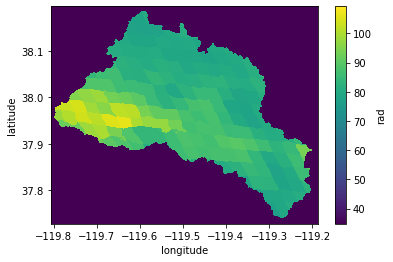

In [10]:
example_ds = xr.open_dataset('test_ortho.nc')
example_ds.rad.plot(x='longitude',y='latitude')
print(example_ds)
print(example_ds.rad)
example_ds.close()

****

Old tests:

#### Does the projection info in the image match our mapping?

In [5]:
print(image.goes_imager_projection.longitude_of_projection_origin)
print(tuol_test.longitude_of_projection_origin)

-89.5
-89.5


#### Map and clip the image to the pixel map

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


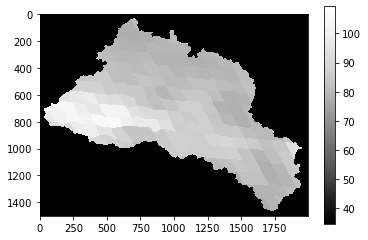

In [6]:
# this finds the nearest x and y in the GOES ABI image for each DEM grid cell and returns the Rad values
# in the same shape and size as the original DEM
rad_values = image.sel(x=tuol_test.dem_px_angle_x, y=tuol_test.dem_px_angle_y, method='nearest').Rad.values
print(rad_values.shape)
plt.imshow(rad_values, cmap='Greys_r')
plt.colorbar()

#### Save this out as a NetCDF file:

In [7]:
# some metadata for this
metadata = {'rad' : 'units'}

# make the data array
rad_da = xr.DataArray(rad_values, 
                      dims=('y','x'),
                      coords={'longitude': (['x'], tuol_test.longitude),
                              'latitude': (['y'], tuol_test.latitude)},
                     attrs=metadata)
tuol_test['rad'] = rad_da
tuol_test.to_netcdf('example.nc')

Read this back in to double check what we ended up with

<xarray.Dataset>
Dimensions:         (x: 1995, y: 1501)
Coordinates:
    longitude       (x) float64 ...
    latitude        (y) float64 ...
    dem_px_angle_x  (y, x) float64 ...
    dem_px_angle_y  (y, x) float64 ...
Dimensions without coordinates: x, y
Data variables:
    elevation       (y, x) float64 ...
    rad             (y, x) float32 ...
Attributes:
    longitude_of_projection_origin:                 -89.5
    semi_major_axis:                                6378137
    semi_minor_axis:                                6356752.31414
    perspective_point_height+semi_major_axis:       42164160
    grs80_eccentricity:                             0.0818191910435
    longitude_of_projection_origin_info:            longitude of geostationar...
    semi_major_axis_info:                           semi-major axis of GRS 80...
    semi_minor_axis_info:                           semi-minor axis of GRS 80...
    perspective_point_height+semi_major_axis_info:  distance from center of e...
 

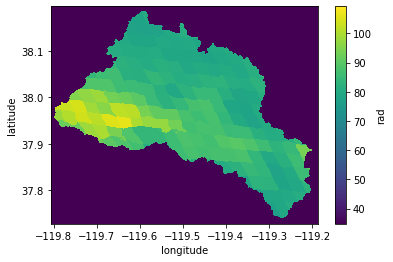

In [8]:
example_ds = xr.open_dataset('example.nc')
example_ds.rad.plot(x='longitude',y='latitude')
print(example_ds)
print(example_ds.rad)
example_ds.close()

#### Save this out as a GeoTIFF for now:

In [161]:
dem_filename = 'dem.tif'
dem = rio.open(dem_filename)

import rasterio as rio
# Open and write to this new file
with rio.open('test_ortho3.tif', 
              'w', 
              driver='GTiff',
              height=rad_values.shape[0],
              width=rad_values.shape[1],
              count=1, 
              dtype='float32',
              nodata=-9999,
              crs=dem.crs, 
              transform=dem.transform) as dst:

    dst.write(rad_values, 1)

Function for making a quick elevation versus radiance plot for the IR channels

In [148]:
def make_elev_rad_plot(fname,rad_values):
    rad_da = xr.DataArray(rad_values, 
                      dims=('y','x'),
                      coords={'longitude': (['x'], tuol_test.longitude),
                              'latitude': (['y'], tuol_test.latitude)})
    #rad_da.plot(x='longitude', y='latitude')
    tuol_test['rad'] = rad_da
    plt.plot(tuol_test.rad,tuol_test.elevation,'.',c='tab:blue',alpha=0.01);
    plt.xlabel('Radiance')
    plt.ylabel('Elevation')
    plt.xlim((50,100))
    plt.savefig(fname+'_elev_vs_radiance.jpg')
    plt.close()

***

## Orthorectify a time series of GOES images

In [19]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

In [24]:
#  all the observations from a directory path
path = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\goes16\2017\04\21\ABI-L1b-RadC\17\C14'
print('Load all observations from the directory provided')
file_list = []
try:
    file_list.append(getListOfFiles(path))
except FileNotFoundError:
    print('Could not find files at {}'.format(path))

Load all observations from the directory provided


In [23]:
file_list = file_list[0]

For each file, orthorectify and output a thumbnail image


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


KeyboardInterrupt: 

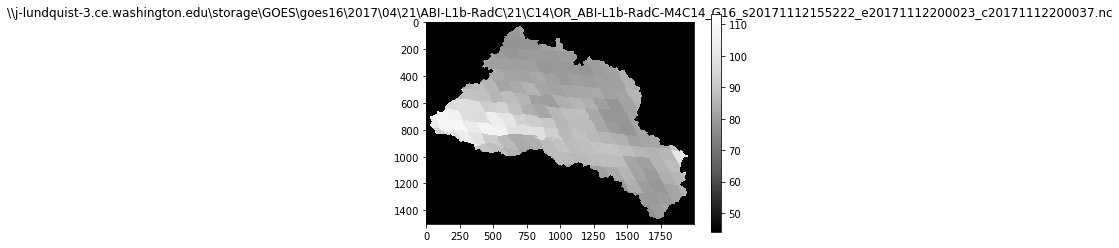

In [152]:
# For each file, orthorectify and output a GeoTiff
print('For each file, orthorectify and output a thumbnail image')

for filename in file_list:
    with xr.open_dataset(filename) as f:
        # this finds the nearest x and y in the GOES ABI image for each DEM grid cell and returns the Rad values
        # in the same shape and size as the original DEM
        s = f.sel(x=tuol_test.dem_px_angle_x, y=tuol_test.dem_px_angle_y, method='nearest').Rad.values
        print(s.shape)
        # make an elevation versus radiance plot
        make_elev_rad_plot(filename,s)
        # make a thumbnail image
        plt.imshow(s, cmap='Greys_r')
        plt.colorbar()
        plt.title(filename)
        plt.tight_layout()
        plt.savefig(filename+'_orthorectified.jpg')
        plt.close()

Try with xarray multifile dataset

In [38]:
# open this entire dataset as a "multi-file dataset"
# For each file, orthorectify and output a GeoTiff
print('Open as multi-file dataset')
print('For each file, orthorectify and output a GeoTiff')

with xr.open_mfdataset(file_list[0], concat_dim=['t']) as g:
    # this finds the nearest x and y in the GOES ABI image for each DEM grid cell and returns the Rad values
    # in the same shape and size as the original DEM
    print(g)
    s = g.sel(x=tuol_test.dem_px_angle_x, y=tuol_test.dem_px_angle_y, t=g.t[0], method='nearest').Rad.values
    print(s.shape)
    #plt.imshow(s, cmap='Greys_r')
    #plt.colorbar()
    #plt.title(filename)
    #plt.tight_layout()
    #plt.savefig(filename+'.jpg')
    #plt.close()

Open as multi-file dataset
For each file, orthorectify and output a GeoTiff
<xarray.Dataset>
Dimensions:                                 (band: 1, num_star_looks: 24, number_of_image_bounds: 2, number_of_time_bounds: 2, t: 2, x: 2500, y: 1500)
Coordinates:
  * y                                       (y) float32 0.126532 ... 0.042588003
  * x                                       (x) float32 -0.075012 ... 0.064932
    y_image                                 float32 0.08456
    x_image                                 float32 -0.00504
    band_id                                 (band) int8 14
    band_wavelength                         (band) float32 11.2
    t_star_look                             (num_star_looks) datetime64[ns] 2000-01-01T11:43:21 ... 2000-01-01T11:43:21
    band_wavelength_star_look               (num_star_looks) float32 -999.0 ... -999.0
  * t                                       (t) datetime64[ns] 2017-04-21T17:02:42.609913920 2017-04-21T17:07:42.611765056
Dimension

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


KeyboardInterrupt: 